# Evolution of Einstein's equations

# Initial data , setting length of the domain and discretization


In [75]:
# Parameters
m = 1
A = 0.1124921875#0.125
run = 1

1

In [76]:
"""res=m;
N=2.0^m*100#2.0^m*1000.0;#2.0^m*500.0;#N=2.0^m*500.0#2.0^m*100.0;
Xf=1.0;

dx=Xf/N;
dt=round(dx,digits=10);
Nt=2^m*100.0#100.0*2^m*10
Tf=Nt*dt; #final time

println("the final time is ", Tf)"""

"res=m;\nN=2.0^m*100#2.0^m*1000.0;#2.0^m*500.0;#N=2.0^m*500.0#2.0^m*100.0;\nXf=1.0;\n\ndx=Xf/N;\ndt=round(dx,digits=10);\nNt=2^m*100.0#100.0*2^m*10\nTf=Nt*dt; #final time\n\nprintln(\"the final time is \", Tf)"

In [77]:
res=m;
N=2.0^m*750.0/2#2.0^m*1000.0;#2.0^m*500.0;#N=2.0^m*500.0#2.0^m*100.0;
Xf=1.0;

dx=Xf/N;
dt=0.8*round(dx,digits=10);
Nt=2^m*750/2#100.0*2^m*10
Tf=Nt*dt; #final time
print(Tf)

0.79999998

In [78]:
print(N)

750.0

In [79]:
println("dx =", dx)
println("dt =", dt)
println("dx/dt =", dx/dt)
println("epsilon <= dx/dt * (1/2)^(2*2-1) = ", dx/dt*(1/2)^(2*2-1))

println("epsilon = dx/dt * (1/2)^(2*2) = ", dx/dt*(1/2)^(2*2))

println("epsilon = dx/dt * (1/2)^(2*3) = ", dx/dt*(1/2)^(2*3))

println("epsilon = dx/dt * (1/2)^(2) = ", dx/dt*(1/2)^(2))

dx =0.0013333333333333333
dt =0.00106666664
dx/dt =1.2500000312500008
epsilon <= dx/dt * (1/2)^(2*2-1) = 0.1562500039062501
epsilon = dx/dt * (1/2)^(2*2) = 0.07812500195312505
epsilon = dx/dt * (1/2)^(2*3) = 0.019531250488281263
epsilon = dx/dt * (1/2)^(2) = 0.3125000078125002


In [80]:
# Setting RESOLUTION

global dir = "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res$res"
#global dir = "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res"

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res1"

In [81]:
epsilon=0.1##0.01#0.05; #05; #02;#0.05; #0.05; #0.05;#0.05;#0.05; #dissipation strength (-1 for backwards integration)

0.1

# Grid

In [82]:
ori=0.0;
initX1 = nothing
initX1=range(ori, stop=Xf, step=dx);

In [83]:
initX = range(round(ori-3.0*dx,digits=10), stop=Xf+3.0*dx, step=dx)

L=length(initX);
println("step size is  ", dx)

#T=range(dt,stop=Tf,step=dt)
T=range(0,stop=Tf,step=dt)
println("the time step is ", dt)

step size is  0.0013333333333333333
the time step is 0.00106666664


In [84]:
include("./ScalarField.jl");

# Initial data of m β Ψ and Ψ,x

In [85]:
using PyCall   
using Interpolations

scipy = pyimport("scipy")
scipyinterpolate = pyimport("scipy.interpolate")


####

initm=zeros(L);
initbeta=zeros(L);
initpsi=zeros(L);
initderpsi=zeros(L);

state_array=[initm initbeta initpsi initderpsi initX];

#PSI
r0=0.7#0.3
sigma=0.3
initpsi[4:L-3] = init_gaussian(initX1,r0,sigma,A)

state_array[:,3] = initpsi
state_array = ghost(state_array)

#PSI,X FROM PSI
"""for i in 4:L-3
    initderpsi[i]=Der(state_array[:,:],i,3,initX)
end

state_array[:,4] = initderpsi
state_array = ghost(state_array)"""

#new
initderpsi[4:L-3] = init_gaussian_der(initX1,r0,sigma,A)
state_array[:,4] = initderpsi
state_array=ghost(state_array)

####

"""spl_psi = scipyinterpolate.splrep(initX[4:L-3], state_array[4:L-3,3],k=4)
psi_func(x) = scipyinterpolate.splev(x, spl_psi)

spl_derpsi = scipyinterpolate.splrep(initX[4:L-3], initderpsi[4:L-3],k=4)
derpsi_func(x) = scipyinterpolate.splev(x, spl_derpsi)"""
psi_func = cubic_spline_interpolation(initX[4:L-3], state_array[4:L-3,3],  extrapolation_bc = Line())
derpsi_func = cubic_spline_interpolation(initX[4:L-3], initderpsi[4:L-3],  extrapolation_bc = Line())

funcs = [psi_func, derpsi_func];

In [86]:
#BETA
beta0=0
initbeta[4:L-3]=rk4wrapper(SFconstraint_beta,beta0,initX1,0,funcs)
state_array[:,2]=initbeta;
state_array=ghost(state_array);


#M
m0=0
initm[4:L-3]=rk4wrapper(SFconstraint_m,m0,initX1,0,funcs)
state_array[:,1]=initm;
state_array = ghost(state_array);

In [87]:
"""using Plots #showing initial data and the initial status of the horizon finder
plot(initX, state_array[:,1:4], xaxis="x",title="Initial Data", labels=["m" "beta" "psi" "psi,x"])"""

"using Plots #showing initial data and the initial status of the horizon finder\nplot(initX, state_array[:,1:4], xaxis=\"x\",title=\"Initial Data\", labels=[\"m\" \"beta\" \"psi\" \"psi,x\"])"

# Defining the initial state array for the evolution m β Ψ and Ψ,x

In [88]:
using CSV, Tables
#CSV.write(dir*"/time_step0.csv", Tables.table(transpose(Matrix(state_array))), writeheader=false)
CSV.write(dir*"/time_step0.csv", Tables.table(state_array), writeheader=false)

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res1/time_step0.csv"

In [89]:
timestep=0
criticality=0.0
explode=0.0
evol_stats = [run criticality A sigma r0 timestep explode]
monitor_ratio = zeros(L)
CSV.write("/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/parameters.csv", Tables.table(evol_stats), writeheader=true, header=["run", "criticality", "A", "sigma", "r0", "timestep", "explode"])

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/parameters.csv"

 ## Time evolution

fixed grid

In [90]:
finaltime=length(T)-1
timeevolution(state_array,finaltime,dir,res,run)

Progress: 100%|█████████████████████████████████████████| Time: 0:31:19


boom at t=579


1×7 Matrix{Float64}:
 0.0  0.112492  0.3  0.7  579.0  0.0  1.0

## Movie of the evolution

[ Info: Saved animation to /home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/anim_res1.gif


Plots.AnimatedGif("/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/anim_res1.gif")
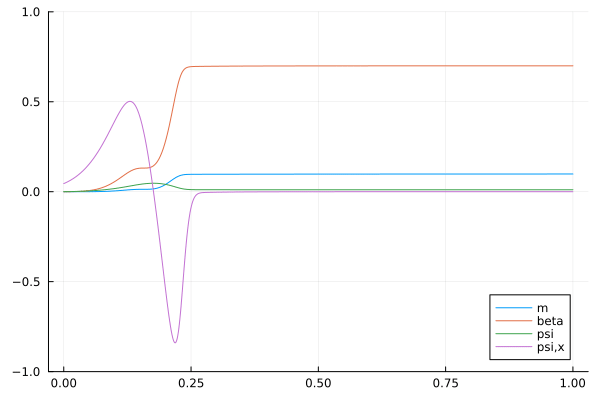

In [74]:
using Plots, CSV, DataFrames
import GR
anim = @animate for n in 400:447#length(T)-1
    
    time_step=T[n+1]-T[n];
    IJulia.clear_output(true)
    
    functions3=DataFrame(CSV.File(dir*"/time_step$n.csv",header=false, delim=","))
    plot()
        plot1=functions3.Column1[4:L-3];
        plot2=functions3.Column2[4:L-3];
        plot3=functions3.Column3[4:L-3];
        plot4=functions3.Column4[4:L-3];
        plot5=functions3.Column5[4:L-3];
    d=round(T[n],digits=1)
    #plot!(X1, [plot1 plot2 plot3 plot4], labels=["m" "beta" "psi" "psi,x"],ylim=[-0.1,0.1], xlim=[0, 0.1]) |> display 
    plot!(initX[4:L-3], [plot1 plot2 plot3 plot4], labels=["m" "beta" "psi" "psi,x"],ylim=[-1,1])#, xlim=[0, 0.1]) |> display 
    
    end

gif(anim, "anim_res$res.gif", fps = 1)

In [66]:
dir

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res1"